We shall now simulate an infinitely long vertical insulating wall with holes by taking a single, finite section of the wall and imposing a periodic boundary condition at the top and bottom of the region. A periodic boundary condition means $T(x, y_{\text{bot}}) = T(x, y_{\text{top}})$. With this boundary condition only one central hole is needed.

To simulate an infinitely long wall, we model a single, repeating vertical section of height $\delta$ and apply periodic boundary conditions at the top and bottom. This means the temperature at the top edge of our simulation box is forced to be equal to the temperature at the bottom edge.

For any point $T_{i, j}$ in a grid with $N$ rows,
*   The upper neighbor is at row $i + 1 \bmod N$.
*   For a point on the top edge $i = N-1$, this becomes $N-1 + 1 \bmod N = N \bmod N = 0$. The ghost point above the top edge is simply the point on the bottom edge.
*   The lower neighbor is at row $i - 1 + N \bmod N$.
*   For a point on the bottom edge $i = 0$, this becomes $0 - 1 + N \bmod N = N-1$. The ghost point below the bottom edge is the point on the top edge.

In [15]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def create_wall_mask(N, epsilon, delta):
    '''
    Creates a boolean mask for the insulating wall with holes.
    Args:
        N: The number of grid points in each direction.
        epsilon: The size of the holes.
        delta: The spacing between holes.
    Returns:
        A boolean array where True indicates an insulator.
    '''
    is_insulator = np.full((N + 1, N + 1), False)

    # Place the wall as a solid line in the middle column
    wall_j = N // 2
    is_insulator[:, wall_j] = True

    # Convert real-world dimensions to grid units
    hole_size_grid = int(epsilon * N)
    block_size_grid = int((epsilon + delta) * N)

    if hole_size_grid <= 0:
        return is_insulator # Return a solid wall if hole size is invalid

    # Start from the center of the grid and work outwards
    center_i = N // 2

    # Place central hole
    start_i = center_i - hole_size_grid // 2
    end_i = start_i + hole_size_grid
    # Check if the whole hole fits
    if start_i >= 0 and end_i <= N:
        is_insulator[start_i:end_i, wall_j] = False

    # Place holes symmetrically above and below the center
    k = 1
    while True:
        holes_were_placed_this_iteration = False

        # Attempt to place hole above center
        hole_center_up = center_i + k * block_size_grid
        start_i_up = hole_center_up - hole_size_grid // 2
        end_i_up = start_i_up + hole_size_grid

        # Check if the entire hole fits within the bounds [0, N]
        if start_i_up >= 0 and end_i_up <= N:
            is_insulator[start_i_up:end_i_up, wall_j] = False
            holes_were_placed_this_iteration = True

        # Attempt to place hole below center
        hole_center_down = center_i - k * block_size_grid
        start_i_down = hole_center_down - hole_size_grid // 2
        end_i_down = start_i_down + hole_size_grid

        # Check if the entire hole fits within the bounds [0, N]
        if start_i_down >= 0 and end_i_down <= N:
            is_insulator[start_i_down:end_i_down, wall_j] = False
            holes_were_placed_this_iteration = True

        # If we could not place any new holes, then we are done
        if not holes_were_placed_this_iteration:
            break

        k += 1

    return is_insulator


def solve_laplace_with_wall(N=80, sigma=1.9, tol=1e-6, max_iter=20000, epsilon=0.1, delta=0.15):
    '''
    Solves Laplace's equation for a unit square with an internal insulating wall.
    '''
    # Initialisation
    T = np.full((N + 1, N + 1), 0.5)
    is_insulator = create_wall_mask(N, epsilon, delta)

    # Apply Fixed Boundary Conditions
    T[:, 0] = 0.0  # Left side
    T[:, N] = 1.0  # Right side

    # Iteration Loop

    for iteration in range(max_iter):
        T_old = T.copy()

        # Update all non-fixed points using Gauss-Seidel
        for i in range(N + 1):
            for j in range(1, N):

                # Skip points that are part of the insulator wall
                if is_insulator[i, j]:
                    continue

                # Determine neighbor values using ghost point logic for boundaries

                # Top neighbor (Neumann boundary at y=1)
                term_U = T[i - 1, j] if i == N else T[i + 1, j]

                # Bottom neighbor (Neumann boundary at y=0)
                term_D = T[i + 1, j] if i == 0 else T[i - 1, j]

                # Right neighbor (check for insulator)
                term_R = T[i, j - 1] if is_insulator[i, j + 1] else T[i, j + 1]

                # Left neighbor (check for insulator)
                term_L = T[i, j + 1] if is_insulator[i, j - 1] else T[i, j - 1]

                # Apply the successive over-relaxation formula
                T[i, j] = (1 - sigma) * T_old[i, j] + (sigma / 4.0) * (term_U + term_D + term_R + term_L)

        # Check for Convergence
        max_change = np.abs(T - T_old).max()

        if max_change < tol:
            break
    else:
        print(f"Maximum number of iterations ({max_iter}) reached.")

    return T, is_insulator, iteration + 1

In [16]:
def create_periodic_wall_mask(Nx, Ny, hole_size_grid):
    '''
    Creates a boolean mask for a single period of the wall.
    The wall has one centrally located hole.
    Args:
        Nx: Number of grid intervals in x-direction.
        Ny: Number of grid intervals in y-direction (height of the period).
        hole_size_grid: The height of the hole in grid points.
    Returns:
        A boolean array where True indicates an insulator.
    '''
    # Grid has Ny rows (0 to Ny-1) and Nx+1 columns (0 to Nx)
    is_insulator = np.full((Ny, Nx + 1), False)

    # Place the solid wall in the middle column
    wall_j = Nx // 2
    is_insulator[:, wall_j] = True

    # Centrally punch a single hole in the wall mask
    center_i = Ny // 2
    start_hole = center_i - hole_size_grid // 2
    end_hole = start_hole + hole_size_grid

    # Ensure start/end points are valid indices
    start_hole = max(0, start_hole)
    end_hole = min(Ny, end_hole)

    is_insulator[start_hole:end_hole, wall_j] = False

    return is_insulator

def solve_laplace_periodic(Nx, Ny, hole_size_grid, sigma=1.9, tol=1e-6, max_iter=20000):
    '''
    Solves Laplace's equation for a unit square with a periodic
    internal insulating wall.
    '''
    # Initialisation
    T = np.full((Ny, Nx + 1), 0.5)
    is_insulator = create_periodic_wall_mask(Nx, Ny, hole_size_grid)

    # Apply Fixed Boundary Conditions (Left/Right)
    T[:, 0] = 0.0
    T[:, Nx] = 1.0

    # Iteration Loop
    for iteration in range(max_iter):
        T_old = T.copy()

        # Update all non-fixed points
        # Loop over all rows (i) and interior columns (j)
        for i in range(Ny):
            for j in range(1, Nx):

                # Skip points that are part of the insulator wall
                if is_insulator[i, j]:
                    continue

                # Get neighbor indices using periodic logic for vertical direction
                up_i = (i + 1) % Ny
                down_i = (i - 1 + Ny) % Ny # Add Ny to handle python's % for negatives

                term_U = T[up_i, j]
                term_D = T[down_i, j]

                # Horizontal neighbor logic is unchanged (checks for insulator)
                term_R = T[i, j - 1] if is_insulator[i, j + 1] else T[i, j + 1]
                term_L = T[i, j + 1] if is_insulator[i, j - 1] else T[i, j - 1]

                # Apply the successive over-relaxation formula
                T[i, j] = (1 - sigma) * T_old[i, j] + \
                          (sigma / 4.0) * (term_U + term_D + term_R + term_L)

        # Check for Convergence
        max_change = np.abs(T - T_old).max()

        if max_change < tol:
            break
    else:
        print(f"Maximum number of iterations ({max_iter}) reached.")

    return T, is_insulator

def plot_periodic_contours(T, is_insulator, num_tiles=3):
    '''
    Plots the temperature contours, tiling the result vertically.
    '''
    Ny, Nx_plus_1 = T.shape
    Nx = Nx_plus_1 - 1

    # Tile the results vertically to show the repeating pattern
    T_tiled = np.tile(T, (num_tiles, 1))
    wall_tiled = np.tile(is_insulator, (num_tiles, 1))

    # Create meshgrid for plotting
    # y-axis now represents multiple periods
    x = np.linspace(0, 1, Nx + 1)
    y = np.linspace(0, num_tiles, num_tiles * Ny)
    X, Y = np.meshgrid(x, y)

    plt.figure(figsize=(6, 8))
    cp = plt.contourf(X, Y, T_tiled, levels=30, cmap='inferno')
    plt.colorbar(cp, label='Temperature (T)', cmap='inferno')

    # Overlay the tiled insulator wall
    plt.contour(X, Y, wall_tiled, levels=[0.5], colors='black', linewidths=2)

    plt.title("Temperature Distribution for Infinite Periodic Wall")
    plt.xlabel("x")
    plt.ylabel("y (in units of period δ)")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

For this new model, the definition of the insulator quality $Q$ needs to be reconsidered to allow for meaningful comparisons. For the finite square, this was defined as the total heat flux across the $x=1$ boundary over a fixed height of $1.0$, given by the formula
\begin{equation}
    Q = -\int_0^1 \kappa\frac{\partial T}{\partial x}\,dy.
\end{equation}
In the periodic model, the simulation domain has a variable height equal to the period $\delta$. If we use the same formula, but integrating to $y=\delta$, then we would be calculating the total flux for just one period. This value would naturally decrease as $\delta$ decreases. Instead, the most appropriate measure is the average heat flux per unit length, which we will continue to call $Q$, abusing notation. It is calculated by taking the total flux for one period and dividing by the height of that period
\begin{equation}
    Q = -\frac{1}{\delta}\int_0^\delta \kappa\frac{\partial T}{\partial x}\,dy,
\end{equation}
which represents the average heat flow that would cross a $1$ high section of an infinitely long wall.

The key parameter that governs the insulating quality is the ratio of the hole size to the period height $\epsilon/\delta$ which represents the porosity of the wall. We expect that as this ratio increases, the wall will become a worse insulator, and the magnitude of $Q$ will increase.

In [17]:
def calculate_q_density_periodic(T, N_x, N_y, delta, kappa=1.0):
    '''
    Calculates the normalized insulator quality Q for the periodic model.
    '''
    # T has shape (N_y, N_x + 1)
    delta_x = 1.0 / N_x
    delta_y = delta / N_y

    dT_dx = (T[:, N_x] - T[:, N_x - 1]) / delta_x
    q_period = -kappa * np.sum(dT_dx) * delta_y

    # Normalise by the period height delta
    q_density = q_period / delta
    return q_density

def calculate_q_finite(T, N, kappa=1.0):
    '''
    Calculates Q for the finite model (height = 1.0).
    '''
    delta_x = 1.0 / N
    dT_dx = (T[:, N] - T[:, N - 1]) / delta_x
    Q = -kappa * np.sum(dT_dx) * delta_x # Here delta_y = delta_x
    return Q

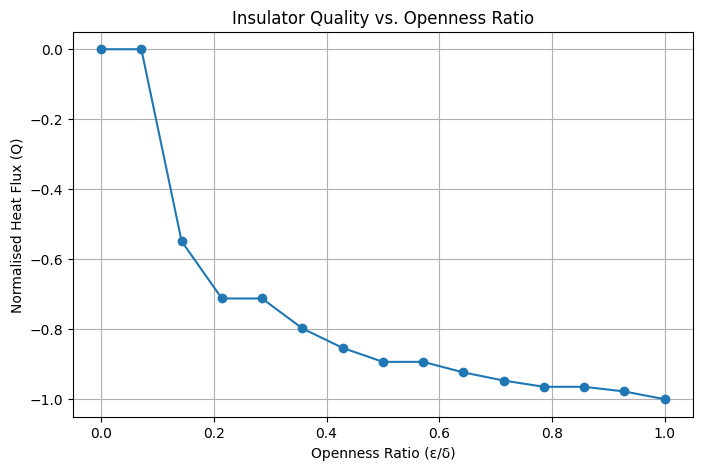

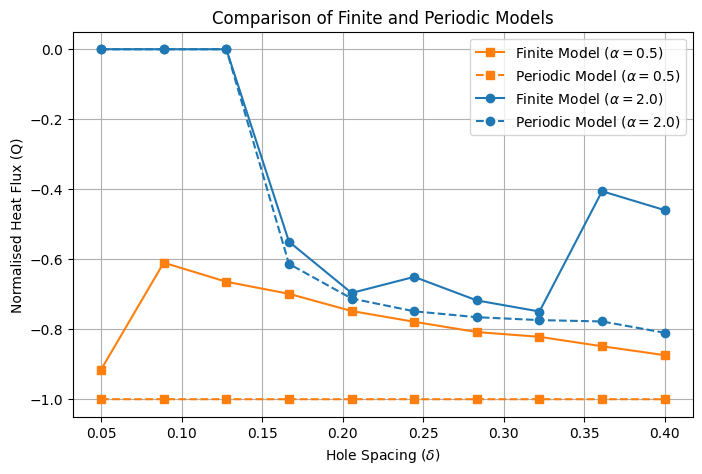

In [21]:
N_VAL = 51
openness_ratios = np.linspace(0, 1, 15)
q_vs_ratio = []
delta_fixed_val = 0.2
Ny_fixed = int(delta_fixed_val * N_VAL)

for ratio in openness_ratios:
    epsilon_val = ratio * delta_fixed_val
    hole_grid = int(epsilon_val * N_VAL)

    T, _ = solve_laplace_periodic(N_VAL, Ny_fixed, hole_grid, tol=1e-5, max_iter=5000)
    q = calculate_q_density_periodic(T, N_VAL, Ny_fixed, delta_fixed_val)
    q_vs_ratio.append(q)

plt.figure(figsize=(8, 5))
plt.plot(openness_ratios, q_vs_ratio, 'o-')
plt.title('Insulator Quality vs. Openness Ratio')
plt.xlabel('Openness Ratio (ε/δ)')
plt.ylabel('Normalised Heat Flux (Q)')
plt.grid(True)
plt.show()


delta_range = np.linspace(0.05, 0.4, 10)
# Data for alpha = 1.0
q_finite_a1 = []
q_periodic_a1 = []
# Data for alpha = 2.0
q_finite_a2 = []
q_periodic_a2 = []

for delta in delta_range:
    epsilon_a1 = 1.0 * (delta ** 0.5)
    T_fin_a1, _, _ = solve_laplace_with_wall(N=N_VAL, epsilon=epsilon_a1, delta=delta, tol=1e-5, max_iter=5000)
    Ny_a1 = int(delta * N_VAL)
    hole_grid_a1 = int(epsilon_a1 * N_VAL)
    T_per_a1, _ = solve_laplace_periodic(N_VAL, Ny_a1, hole_grid_a1, tol=1e-5, max_iter=5000)
    q_finite_a1.append(calculate_q_finite(T_fin_a1, N_VAL))
    q_periodic_a1.append(calculate_q_density_periodic(T_per_a1, N_VAL, Ny_a1, delta))

    epsilon_a2 = 1.0 * (delta ** 2)
    T_fin_a2, _, _ = solve_laplace_with_wall(N=N_VAL, epsilon=epsilon_a2, delta=delta, tol=1e-5, max_iter=5000)
    Ny_a2 = int(delta * N_VAL)
    hole_grid_a2 = int(epsilon_a2 * N_VAL)
    T_per_a2, _ = solve_laplace_periodic(N_VAL, Ny_a2, hole_grid_a2, tol=1e-5, max_iter=5000)
    q_finite_a2.append(calculate_q_finite(T_fin_a2, N_VAL))
    q_periodic_a2.append(calculate_q_density_periodic(T_per_a2, N_VAL, Ny_a2, delta))

plt.figure(figsize=(8, 5))
plt.plot(delta_range, q_finite_a1, 's-', color='C1', label=r'Finite Model ($\alpha=0.5$)')
plt.plot(delta_range, q_periodic_a1, 's--', color='C1', label=r'Periodic Model ($\alpha=0.5$)')
plt.plot(delta_range, q_finite_a2, 'o-', color='C0', label=r'Finite Model ($\alpha=2.0$)')
plt.plot(delta_range, q_periodic_a2, 'o--', color='C0', label=r'Periodic Model ($\alpha=2.0$)')

plt.title('Comparison of Finite and Periodic Models')
plt.xlabel('Hole Spacing ($\\delta$)')
plt.ylabel('Normalised Heat Flux (Q)')
plt.legend()
plt.grid(True)
plt.show()

As the openness ratio $\epsilon/\delta$, the magnitude of the heat flux $Q$ also increases from $0$ to $1$, representing a solid wall (perfect insulator) and an open wall (perfect conductor). The curve is not a straight line as the insulating effect is most sensitive to changes when the wall is mostly solid. This indicates even a few holes can heavily affect the insulation.

The periodic boundary condition model is an idealisation. It represents a material with a perfectly repeating internal structure, free from the edge effects of a finite square. For $\alpha > 1$, the periodic model is similar to the finite model for smaller $\delta$, where the size of holes incredibly fine. For $\alpha < 1$, the models are the most comparable for larger $\delta$, where the holes are large.